# nb 105: Mock-make

In this notebook, we instantiate an empty model, putting together all of our parts.

In [1]:
import math
import os
import random
import sys
import struct
import warnings

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# Importing all the layers, even though some are redundant.
from library import pc, quantize, sample_points, augment_pc_with_offsets
from library import VFE_FCN, ElementwiseMaxpool, PointwiseConcat, VFE, VFE_out
from library import ConvMiddleLayer, RPNConvBlock

## 1. VFE

### 1.1. VFE partition, group, and sample

TODO: The data-augmentation part if we are training.

In [5]:
print(pc.shape)

# smaller input shape, so it's easier to put all together
quantized_points, indices = sample_points(
    pointcloud = pc,
    #vD = 0.5,
    #vH = 5,
    #vW = 5
)

print(f"Shape (D, H, W, T, 7) = {quantized_points.shape}")

(2331, 4)
Shape (D, H, W, T, 7) = (10, 400, 352, 35, 7)


In [7]:
10 * 400 * 352 * 35 * 7 * 4 / 1024 ** 2

1315.91796875

### 1.2. VFE offset augmentation

In [3]:
voxelgrid = augment_pc_with_offsets(quantized_points)
assert quantized_points.shape == voxelgrid.shape

### 1.3. VFE neural part

In [4]:
vfe_input = keras.Input(shape=voxelgrid.shape)
vfe_h1 = VFE(cin = 7, cout = 32, name="VFE_7-32")(vfe_input)
vfe_h2 = VFE(cin = 32, cout = 128, name="VFE_32-128")(vfe_h1)
vfe_out = VFE_out(CC = 128, axis = 4)(vfe_h2)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


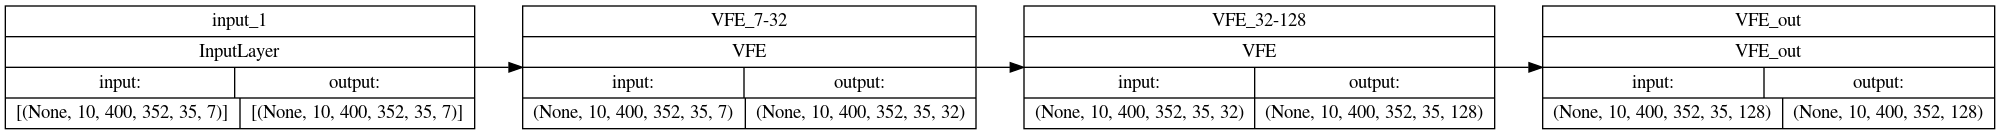

In [5]:
vfe_out_model = keras.Model(inputs = vfe_input, outputs = vfe_out)

keras.utils.plot_model(vfe_out_model, show_shapes=True, expand_nested=True, rankdir='LR')

## 2. Convolutional Middle Layers

Note the shape from the previous `vfe_out_model` is `(D, H, W, 128)`. Here `128` are the number of filters to our CNN.

In [6]:
#conv_input = keras.Input(shape = vfe_out.shape[1:])
# continuing from VFE...
conv_1 = ConvMiddleLayer(
    MM = 3, c_in = 128, c_out = 64,
    kk = 3, ss = (2, 1, 1), pp = (1, 1, 1),
    name = "ConvMiddle_1_"
)(vfe_out)

conv_2 = ConvMiddleLayer(
    MM = 3, c_in = 64, c_out = 64,
    kk = 3, ss = (1, 1, 1), pp = (0, 1, 1),
    name = "ConvMiddle_2_"
)(conv_1)

conv_3 = ConvMiddleLayer(
    MM = 3, c_in = 64, c_out = 64,
    kk = 3, ss = (2, 1, 1), pp = (1, 1, 1),
    name = "ConvMiddle_3_"
)(conv_2)

print(vfe_out.shape, conv_1.shape, conv_2.shape, conv_3.shape, sep="\n")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(None, 10, 400, 352, 128)
(None, 6, 400, 352, 64)
(None, 4, 400, 352, 64)
(None, 3, 400, 352, 64)


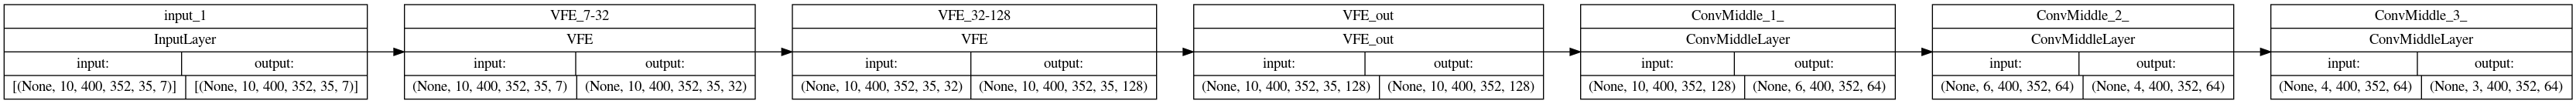

In [7]:
model_so_far_conv = keras.Model(inputs = vfe_input, outputs = conv_3)

keras.utils.plot_model(model_so_far_conv, show_shapes=True, expand_nested=True, rankdir='LR')

## 3. RPN layers

The final layers to the neural network.

First, we need to reshape the previous layer from `(D'', H'', W'', 64)` to `(H'', W'', D'' * 64)`.

In [8]:
#1: reshape the output from the conv middle layers

#rpn_in = keras.Input(shape=(3, 16, 14, 64)) # replace with conv_layers

rpn_in_permute = tf.keras.layers.Permute((2, 3, 1, 4))(conv_3)

# reshape to: Get rid of the batch axis, multiply the last two
reshape_to = rpn_in_permute.shape[1:-2] + (rpn_in_permute.shape[-2] * rpn_in_permute.shape[-1],)
rpn_in_reshape = tf.keras.layers.Reshape(
    input_shape = rpn_in_permute.shape,
    target_shape = reshape_to
)(rpn_in_permute)


In [9]:
#2: Now, actually construct the layers
rpn_block_1 = RPNConvBlock(qq = 4, name = 'rpn_block_1')(rpn_in_reshape)
rpn_block_2 = RPNConvBlock(qq = 6, name = 'rpn_block_2')(rpn_block_1)
rpn_block_3 = RPNConvBlock(qq = 6, name = 'rpn_block_3')(rpn_block_2)

# deconv blocks
rpn_deconv_1 = keras.layers.Conv2DTranspose(
    filters = 256, kernel_size = 3, strides = 1, padding = 'same', name = 'rpn_deconv_1'
)(rpn_block_1)
rpn_deconv_2 = keras.layers.Conv2DTranspose(
    filters = 256, kernel_size = 2, strides = 2, padding = 'same', name = 'rpn_deconv_2'
)(rpn_block_2)
rpn_deconv_3 = keras.layers.Conv2DTranspose(
    filters = 256, kernel_size = 4, strides = 4, padding = 'same', name = 'rpn_deconv_3'
)(rpn_block_3)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [10]:
#3: Output learning targets

deconv_layers = [rpn_deconv_1, rpn_deconv_2, rpn_deconv_3]

# concatenate the 3 deconv blocks
rpn_penultimate = keras.layers.Concatenate(name = 'rpn_penultimate')(deconv_layers)

# Final outputs
probability_score_map = keras.layers.Convolution2D(
    filters = 2,
    kernel_size = 1,
    name = "RPN_prob_score_map",
)(rpn_penultimate)

regression_map = keras.layers.Convolution2D(
    filters = 14,
    kernel_size = 1
)(rpn_penultimate)

RPN_outputs = [probability_score_map, regression_map]

# 4. Final model output

Now that we have all these parts together, let's make (and understand) the model

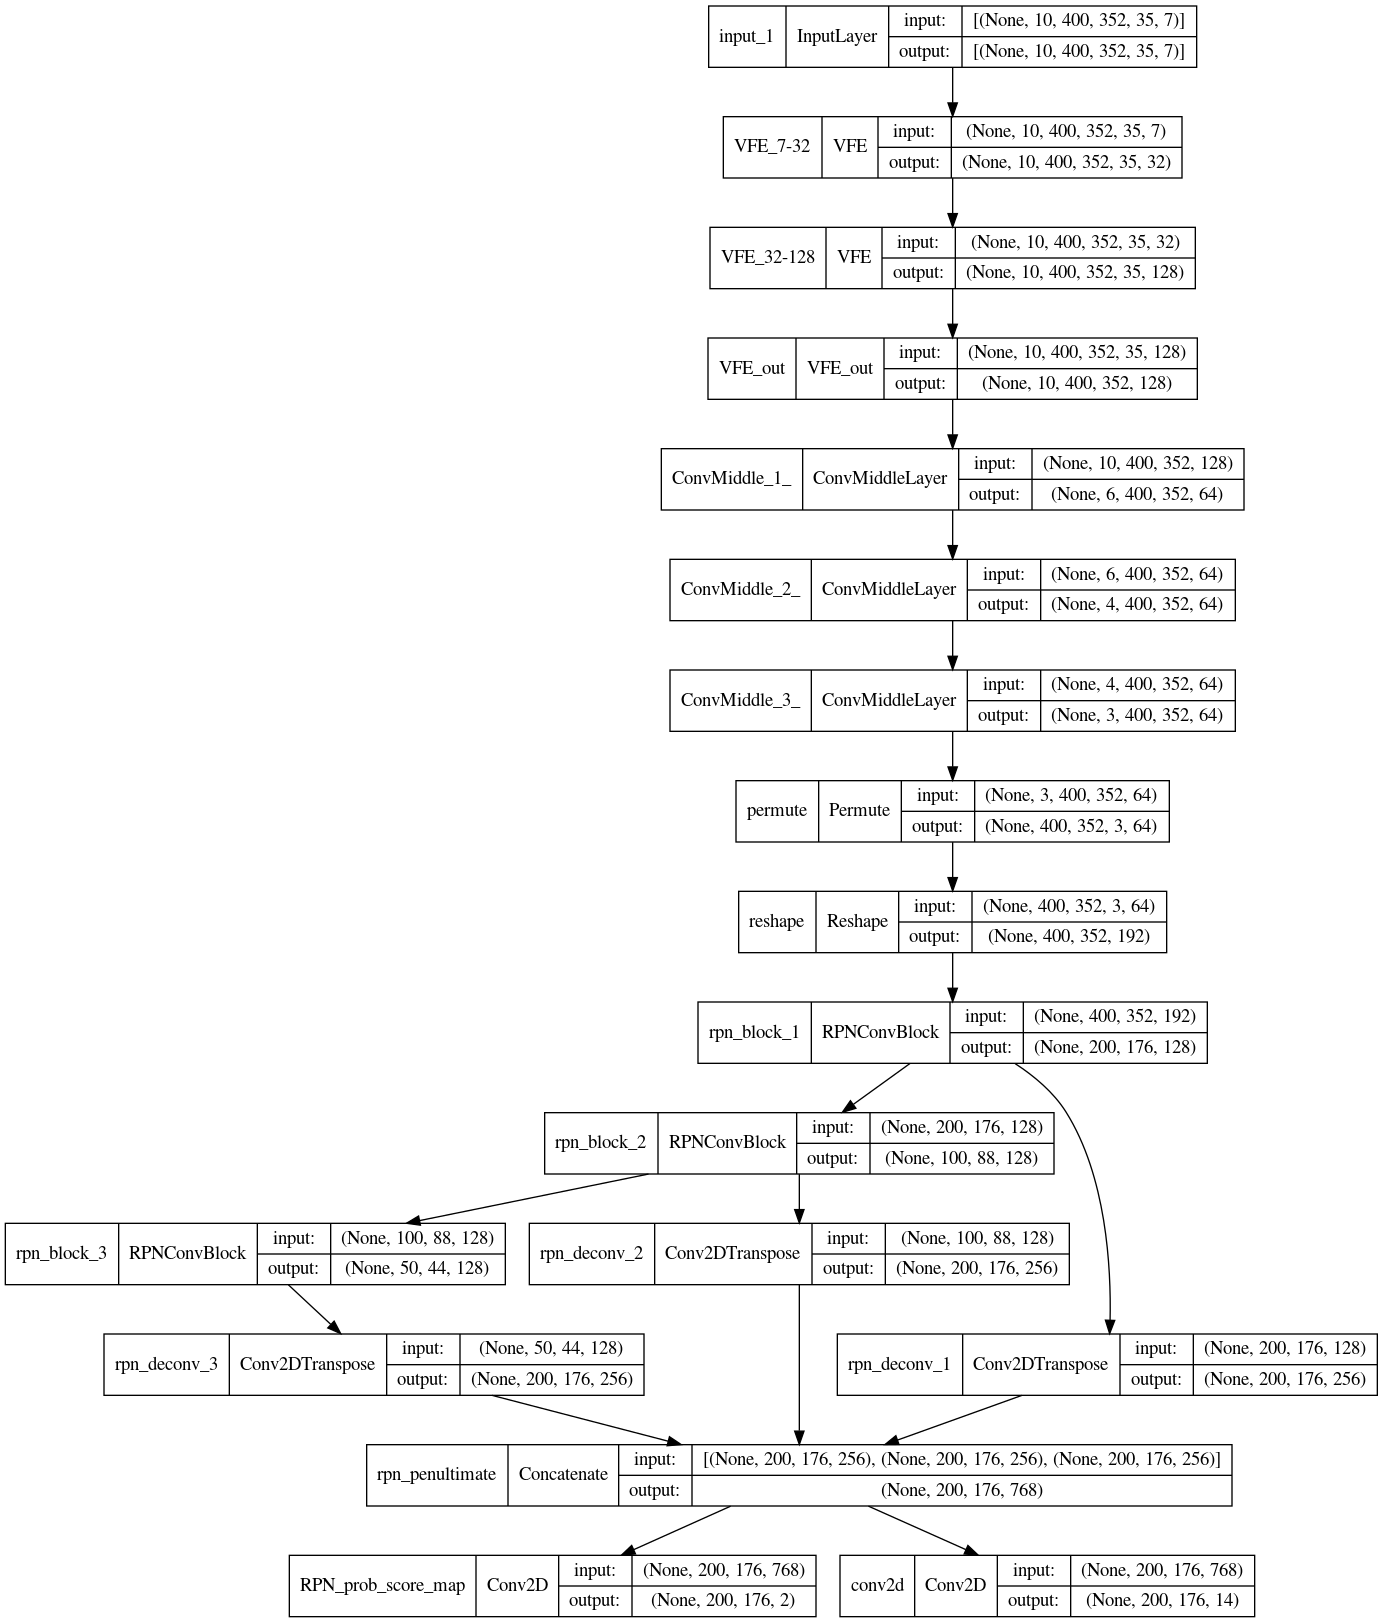

In [11]:
model = keras.Model(
    inputs = vfe_input,
    outputs = RPN_outputs
)

keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

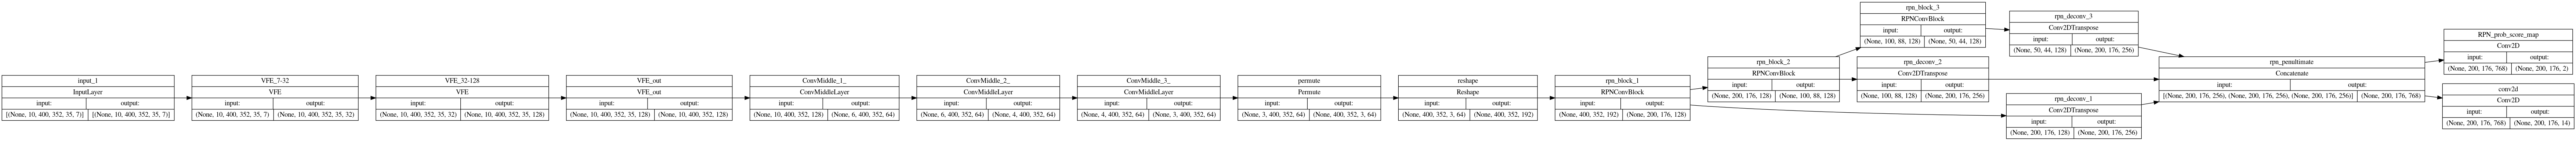

In [12]:
keras.utils.plot_model(model, show_shapes=True, expand_nested=True, rankdir='LR')

In [15]:
model(tf.expand_dims(voxelgrid, 0))

ResourceExhaustedError: Exception encountered when calling layer "VFE_7-32_pointwise_concat" (type PointwiseConcat).

OOM when allocating tensor with shape[1,10,400,352,35,32] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:ConcatV2] name: concat

Call arguments received:
  • xx=['tf.Tensor(shape=(1, 10, 400, 352, 35, 16), dtype=float32)', 'tf.Tensor(shape=(1, 10, 400, 352, 1, 16), dtype=float32)']